# This notebook finetunes the pre-trained CNN for our dataset.

Install the following if not already on machine.

In [1]:
!pip install soundfile
!pip install tqdm
!pip install -U scikit-learn 

In [1]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
import numpy as np
from tqdm import tqdm
import soundfile as sf

from torch.utils.data import Dataset, DataLoader

In [2]:
import torch
import torch.nn as nn

# import the pre-trained vggish pytorch port.
model = torch.hub.load('harritaylor/torchvggish', 'vggish', postprocess=False)
model.eval()

from torchvggish import vggish, vggish_input, vggish_params, mel_features

Using cache found in C:\Users\User/.cache\torch\hub\harritaylor_torchvggish_master


# Load Data

In [3]:
import os
import pandas as pd
import ast

def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

tracks = load('../data/fma_metadata/tracks.csv')
genres = load('../data/fma_metadata/genres.csv')

To download data, go to https://github.com/mdeff/fma

In [4]:
# subset to FMA small dataset.
small = tracks[tracks['set', 'subset'] <= 'small']

There are corrupted MP3s in the FMA dataset, so we do the following to get a vector of these corrupted MP3s, so it does not break our neural network during training.

In [ ]:
bad_mp3 = []
from soundfile import LibsndfileError

for i in tqdm(small.index):
    try:
        path = get_audio_path(AUDIO_DIR, i)
        x = sf.read(path, dtype='int16')
    except LibsndfileError as e:
        bad_mp3.append(path)
        print(e)
        print("error with audio stream, continuing")

In [ ]:
bad_mp3

# these were the mp3s that were corrupted.

# ['../data/fma_small/098/098565.mp3',
#  '../data/fma_small/098/098567.mp3',
#  '../data/fma_small/098/098569.mp3',
#  '../data/fma_small/099/099134.mp3',
#  '../data/fma_small/108/108925.mp3',
#  '../data/fma_small/133/133297.mp3']

In [5]:
# drop the corrupted mp3s from the dataframe.
corrupted_indices = [98565, 98567, 98569, 99134, 108925, 133297]
small = small.drop(corrupted_indices)

# this is to test dataset with smaller sample size
# for testing the samples
# small = small.sample(n=160, replace=False)
# small

In [7]:
# the following gives us a dataframe 
tracks_labeled = small['track', 'genre_top']
tracks_labeled = tracks_labeled.to_frame(name = 'genre_top')

tracks_labeled.index = tracks_labeled.index.rename('track_id')
tracks_labeled.reset_index()
tracks_labeled.reset_index(drop=False, inplace=True)

In [8]:
labels_encoded = LabelEncoder().fit_transform(tracks_labeled['genre_top'])
labels_encoded

array([3, 3, 6, ..., 6, 6, 3])

In [9]:
tracks_labeled['genre_top'] = labels_encoded
tracks_labeled.shape

(7994, 2)

In [10]:
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [11]:
import random
random.seed(254)

train = small.index[small['set', 'split'] == 'training']
val = small.index[small['set', 'split'] == 'validation']
test = small.index[small['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

6394 training examples, 800 validation examples, 800 testing examples


In [12]:
AUDIO_DIR = "../data/fma_small"

In [13]:
class CustomAudioDataset(Dataset):
    def __init__(self, track_ids, transforms=None):
        self.track_ids = track_ids

    def __len__(self):
        return len(self.track_ids)

    def __getitem__(self, index):
        aud_path = get_audio_path(AUDIO_DIR, self.track_ids[index])
        label = torch.from_numpy(tracks_labeled.loc[tracks_labeled['track_id'] == self.track_ids[index], 'genre_top'].values)
        return aud_path, label  

In [14]:
train_dataset = CustomAudioDataset(train)
val_dataset = CustomAudioDataset(val)
test_dataset = CustomAudioDataset(test)

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# created CustomAudioDataset class that returns audio path and label as tuple.
Initialized training and validation datasets.
Intialized training and validation dataloaders.

# Loss Function

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()

# Training Loop

In [17]:
class FintuneModel(nn.Module):
    def __init__(self):
        super(FintuneModel, self).__init__()
        urls = {
            'vggish': "https://github.com/harritaylor/torchvggish/releases/download/v0.1/vggish-10086976.pth"
        }
        self.pretrain = vggish.VGGish(urls, preprocess=False, postprocess=False)
        net_add = nn.Linear(128*31, 256)
        net_add2 = nn.ReLU()
        net_add3 = nn.Linear(256, 8)
        self.classifier = nn.Sequential(net_add, net_add2, net_add3)

    def forward(self, x):
        """
        :param x: [bs, num_frames, 96, 64]
        :return:
        """
        #print(type(x))
        bs, num_frames, _, _ = x.size()
        #print(x.shape)
        x = x.view(bs*num_frames, 1, x.size(2), x.size(3))
        #print(x.shape)
        x = self.pretrain(x) # [bs*num_frames, 128]
        #print(x.shape)
        x = x.view(bs, x.size(1) * num_frames)
        #print(x.shape)
        #print("before classifying")
        x = self.classifier(x)
        #print("after classifying")
        #print(x.shape)
        #print(x)
        return x

In [18]:
FineTuneModel = FintuneModel()
FineTuneModel.eval()

FintuneModel(
  (pretrain): VGGish(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(k

# Optimizer

In [19]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(FineTuneModel.parameters(), lr=0.001, momentum=0.9)

We delete the following mp3s from our dataset. All of these are either 1 second long or don't even play music in preview.

In [20]:
def calculate_accuracy(y_pred, y_true):
    _, predictions = torch.max(y_pred, 1)
    y_true = torch.flatten(y_true)
    correct = (predictions == y_true).sum().item()
    return correct / len(y_true)

In [21]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(tqdm(train_dataloader)):
        # Every data instance is an input + label pair
        inputs, labels = data
        tensor_tuple = ()
        #x = torch.from_numpy(np.empty(len(inputs), ))
        k = 0
        for j in inputs:
            preproc_input = vggish_input.wavfile_to_examples(j, return_tensor=True)
            preproc_input = torch.permute(preproc_input,(1, 0, 2, 3))
            preproc_input = torch.squeeze(preproc_input, dim=0)
            preproc_input = preproc_input.to(device)
            tensor_tuple += (preproc_input,)
            k += 1
            #print(preproc_input.size())
        
        stacked_tensor = torch.stack(tensor_tuple)
        
        # this might solve memory and performance issues
        del preproc_input
        torch.cuda.empty_cache()

        #print(stacked_tensor.shape)
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = FineTuneModel(stacked_tensor)

        del stacked_tensor
        torch.cuda.empty_cache()
        
        # Compute the loss and its gradients
        #print(labels)
        labels = torch.flatten(labels).long().to(device)
        loss = loss_fn(outputs, labels)
        loss.backward()

        del outputs, labels
        torch.cuda.empty_cache()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 25 == 0:
            last_loss = running_loss / 25 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        # if i % 1000 == 999:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(train_dataloader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.

    return last_loss

In [22]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

Moving model to cuda

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [24]:
FineTuneModel = FineTuneModel.to(device) # Move the model to the GPU
val_accuracy = np.array([])

In [26]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/audio_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 11

# comment this back in when training again
best_vloss = 1_000_000. 

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    FineTuneModel.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    FineTuneModel.train(False)

    running_vloss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, vdata in enumerate(tqdm(val_dataloader)):
        vinputs, vlabels = vdata
        vtensor_tuple = ()
        k = 0
        for v in vinputs:
            vpreproc_input = vggish_input.wavfile_to_examples(v, return_tensor = True)
            vpreproc_input = torch.permute(vpreproc_input, (1, 0, 2, 3))
            vpreproc_input = torch.squeeze(vpreproc_input, dim = 0)
            vpreproc_input = vpreproc_input.to(device)
            vtensor_tuple += (vpreproc_input,)
            k +=1
        
        vstacked_tensor = torch.stack(vtensor_tuple)

        # This might solve memory and performance issues
        del vpreproc_input, vtensor_tuple
        torch.cuda.empty_cache()

        # make predictions for this batch of validations
        voutputs = FineTuneModel(vstacked_tensor)

        del vstacked_tensor
        torch.cuda.empty_cache()

        vlabels = torch.flatten(vlabels).long().to(device)
        vloss = loss_fn(voutputs, vlabels)

        # calculating validation accuracy
        vlabels = vlabels
        accuracy = calculate_accuracy(voutputs, vlabels)
        correct_predictions += (accuracy*len(vlabels))
        total_predictions += len(vlabels)
        
        del voutputs, vlabels
        torch.cuda.empty_cache()

        running_vloss += vloss.item()
        del vloss
        torch.cuda.empty_cache()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # calculating accuracy for validation set
    overall_val_accuracy = correct_predictions/total_predictions
    print("Validation accuracy:", overall_val_accuracy)
    val_accuracy = np.append(val_accuracy, overall_val_accuracy)
    
    del overall_val_accuracy, total_predictions, correct_predictions, accuracy

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(FineTuneModel.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


  0%|          | 1/800 [00:09<2:06:26,  9.50s/it]

  batch 1 loss: 0.08249327659606934


  3%|▎         | 26/800 [02:17<1:04:37,  5.01s/it]

  batch 26 loss: 2.055441584587097


  6%|▋         | 51/800 [04:23<1:02:46,  5.03s/it]

  batch 51 loss: 1.9824626731872559


 10%|▉         | 76/800 [06:39<1:02:55,  5.21s/it]

  batch 76 loss: 1.9035465764999389


 13%|█▎        | 101/800 [08:57<1:00:41,  5.21s/it]

  batch 101 loss: 1.7916679859161377


 16%|█▌        | 126/800 [11:12<59:50,  5.33s/it]  

  batch 126 loss: 1.8116939449310303


 19%|█▉        | 151/800 [13:21<55:03,  5.09s/it]  

  batch 151 loss: 1.7487347650527953


 22%|██▏       | 176/800 [15:27<53:09,  5.11s/it]

  batch 176 loss: 1.721889491081238


 25%|██▌       | 201/800 [17:32<49:20,  4.94s/it]

  batch 201 loss: 1.8344010162353515


 28%|██▊       | 226/800 [19:38<47:32,  4.97s/it]

  batch 226 loss: 1.6096932125091552


 31%|███▏      | 251/800 [21:44<45:55,  5.02s/it]

  batch 251 loss: 1.697266058921814


 34%|███▍      | 276/800 [23:49<43:16,  4.95s/it]

  batch 276 loss: 1.6624236512184143


 38%|███▊      | 301/800 [25:53<40:56,  4.92s/it]

  batch 301 loss: 1.664362530708313


 41%|████      | 326/800 [27:59<39:51,  5.05s/it]

  batch 326 loss: 1.5196038722991942


 44%|████▍     | 351/800 [30:05<37:13,  4.98s/it]

  batch 351 loss: 1.5599470949172973


 47%|████▋     | 376/800 [32:09<34:45,  4.92s/it]

  batch 376 loss: 1.4812764978408814


 50%|█████     | 401/800 [34:14<33:03,  4.97s/it]

  batch 401 loss: 1.5253284502029418


 53%|█████▎    | 426/800 [36:20<31:34,  5.07s/it]

  batch 426 loss: 1.3392206048965454


 56%|█████▋    | 451/800 [38:25<28:51,  4.96s/it]

  batch 451 loss: 1.4748730373382568


 60%|█████▉    | 476/800 [40:30<26:59,  5.00s/it]

  batch 476 loss: 1.3907768964767455


 63%|██████▎   | 501/800 [42:35<25:07,  5.04s/it]

  batch 501 loss: 1.508527956008911


 66%|██████▌   | 526/800 [44:39<22:45,  4.98s/it]

  batch 526 loss: 1.4339155650138855


 69%|██████▉   | 551/800 [46:45<20:52,  5.03s/it]

  batch 551 loss: 1.3314744973182677


 72%|███████▏  | 576/800 [48:49<18:43,  5.01s/it]

  batch 576 loss: 1.3266879558563232


 75%|███████▌  | 601/800 [50:53<16:33,  4.99s/it]

  batch 601 loss: 1.4769806551933289


 78%|███████▊  | 626/800 [52:57<14:22,  4.96s/it]

  batch 626 loss: 1.504905116558075


 81%|████████▏ | 651/800 [55:00<12:09,  4.90s/it]

  batch 651 loss: 1.3282027196884156


 84%|████████▍ | 676/800 [57:04<10:15,  4.96s/it]

  batch 676 loss: 1.3012364745140075


 88%|████████▊ | 701/800 [59:06<08:04,  4.89s/it]

  batch 701 loss: 1.407351315021515


 91%|█████████ | 726/800 [1:01:10<06:10,  5.01s/it]

  batch 726 loss: 1.351076192855835


 94%|█████████▍| 751/800 [1:03:15<04:06,  5.04s/it]

  batch 751 loss: 1.446895670890808


 97%|█████████▋| 776/800 [1:05:18<02:00,  5.01s/it]

  batch 776 loss: 1.1970661616325378


100%|██████████| 100/100 [08:11<00:00,  4.91s/it]


LOSS train 1.1970661616325378 valid 1.2662874311208725
Validation accuracy: 0.56125
EPOCH 2:


  0%|          | 1/800 [00:04<1:02:16,  4.68s/it]

  batch 1 loss: 0.054035072326660154


  3%|▎         | 26/800 [02:06<1:02:34,  4.85s/it]

  batch 26 loss: 1.4069241905212402


  6%|▋         | 51/800 [04:09<1:01:12,  4.90s/it]

  batch 51 loss: 1.2683528399467467


 10%|▉         | 76/800 [06:12<59:17,  4.91s/it]  

  batch 76 loss: 1.3104524683952332


 13%|█▎        | 101/800 [08:15<55:56,  4.80s/it] 

  batch 101 loss: 1.3245730900764465


 16%|█▌        | 126/800 [10:17<55:34,  4.95s/it]

  batch 126 loss: 1.2957096552848817


 19%|█▉        | 151/800 [12:20<53:02,  4.90s/it]

  batch 151 loss: 1.3027023959159851


 22%|██▏       | 176/800 [14:22<50:57,  4.90s/it]

  batch 176 loss: 1.1951084017753602


 25%|██▌       | 201/800 [16:25<48:27,  4.85s/it]

  batch 201 loss: 1.2467186427116395


 28%|██▊       | 226/800 [18:28<47:01,  4.91s/it]

  batch 226 loss: 1.2051593160629273


 31%|███▏      | 251/800 [20:30<43:58,  4.81s/it]

  batch 251 loss: 1.2851091480255128


 34%|███▍      | 276/800 [22:32<42:13,  4.84s/it]

  batch 276 loss: 1.113441160917282


 38%|███▊      | 301/800 [24:35<40:27,  4.87s/it]

  batch 301 loss: 1.1964349043369293


 41%|████      | 326/800 [26:38<38:25,  4.86s/it]

  batch 326 loss: 1.1178210532665254


 44%|████▍     | 351/800 [28:40<36:59,  4.94s/it]

  batch 351 loss: 1.0755612647533417


 47%|████▋     | 376/800 [30:42<34:25,  4.87s/it]

  batch 376 loss: 1.2473855328559875


 50%|█████     | 401/800 [32:44<32:32,  4.89s/it]

  batch 401 loss: 1.1665789437294007


 53%|█████▎    | 426/800 [34:46<30:30,  4.89s/it]

  batch 426 loss: 1.1151330506801604


 56%|█████▋    | 451/800 [36:49<28:59,  4.98s/it]

  batch 451 loss: 1.2129190850257874


 60%|█████▉    | 476/800 [38:52<26:32,  4.92s/it]

  batch 476 loss: 1.094171680212021


 63%|██████▎   | 501/800 [40:55<24:13,  4.86s/it]

  batch 501 loss: 1.2922472512722016


 66%|██████▌   | 526/800 [42:57<22:09,  4.85s/it]

  batch 526 loss: 1.2048543298244476


 69%|██████▉   | 551/800 [45:00<20:26,  4.93s/it]

  batch 551 loss: 1.1351785027980805


 72%|███████▏  | 576/800 [47:02<18:20,  4.91s/it]

  batch 576 loss: 1.050949238538742


 75%|███████▌  | 601/800 [49:05<16:34,  5.00s/it]

  batch 601 loss: 1.2216123485565185


 78%|███████▊  | 626/800 [51:07<13:58,  4.82s/it]

  batch 626 loss: 1.1920416951179504


 81%|████████▏ | 651/800 [53:10<12:17,  4.95s/it]

  batch 651 loss: 1.1106152176856994


 84%|████████▍ | 676/800 [55:13<10:15,  4.97s/it]

  batch 676 loss: 1.1565690398216248


 88%|████████▊ | 701/800 [57:16<08:04,  4.89s/it]

  batch 701 loss: 1.1383784699440003


 91%|█████████ | 726/800 [59:20<06:00,  4.87s/it]

  batch 726 loss: 1.2092419624328614


 94%|█████████▍| 751/800 [1:01:22<03:57,  4.84s/it]

  batch 751 loss: 1.1615192353725434


 97%|█████████▋| 776/800 [1:03:25<01:56,  4.85s/it]

  batch 776 loss: 1.1550885796546937


100%|██████████| 100/100 [08:02<00:00,  4.82s/it]


LOSS train 1.1550885796546937 valid 1.2943720418214797
Validation accuracy: 0.54875
EPOCH 3:


  0%|          | 1/800 [00:04<1:05:13,  4.90s/it]

  batch 1 loss: 0.057690787315368655


  3%|▎         | 26/800 [02:06<1:03:08,  4.89s/it]

  batch 26 loss: 1.0236568212509156


  6%|▋         | 51/800 [04:08<1:02:09,  4.98s/it]

  batch 51 loss: 1.0954878330230713


 10%|▉         | 76/800 [06:11<59:08,  4.90s/it]  

  batch 76 loss: 1.3715547966957091


 13%|█▎        | 101/800 [08:13<57:50,  4.96s/it]

  batch 101 loss: 1.0927882933616637


 16%|█▌        | 126/800 [10:16<55:37,  4.95s/it]

  batch 126 loss: 1.2090672063827514


 19%|█▉        | 151/800 [12:18<52:38,  4.87s/it]

  batch 151 loss: 0.977425011396408


 22%|██▏       | 176/800 [14:21<49:58,  4.81s/it]

  batch 176 loss: 1.2124693918228149


 25%|██▌       | 201/800 [16:24<49:51,  4.99s/it]

  batch 201 loss: 0.9247412419319153


 28%|██▊       | 226/800 [18:26<47:23,  4.95s/it]

  batch 226 loss: 1.083365820646286


 31%|███▏      | 251/800 [20:29<45:00,  4.92s/it]

  batch 251 loss: 1.025673885345459


 34%|███▍      | 276/800 [22:32<43:08,  4.94s/it]

  batch 276 loss: 1.0612795841693878


 38%|███▊      | 301/800 [24:35<41:09,  4.95s/it]

  batch 301 loss: 1.0562713325023652


 41%|████      | 326/800 [26:36<38:18,  4.85s/it]

  batch 326 loss: 0.9739929223060608


 44%|████▍     | 351/800 [28:39<37:11,  4.97s/it]

  batch 351 loss: 1.163007298707962


 47%|████▋     | 376/800 [30:43<34:16,  4.85s/it]

  batch 376 loss: 1.1587266826629639


 50%|█████     | 401/800 [32:46<32:08,  4.83s/it]

  batch 401 loss: 1.076380251646042


 53%|█████▎    | 426/800 [34:48<30:49,  4.94s/it]

  batch 426 loss: 1.0611453282833099


 56%|█████▋    | 451/800 [36:51<28:28,  4.90s/it]

  batch 451 loss: 0.9893210911750794


 60%|█████▉    | 476/800 [38:54<26:36,  4.93s/it]

  batch 476 loss: 1.1157766306400299


 63%|██████▎   | 501/800 [40:56<24:25,  4.90s/it]

  batch 501 loss: 1.1360739874839783


 66%|██████▌   | 526/800 [42:59<22:17,  4.88s/it]

  batch 526 loss: 1.219248855113983


 69%|██████▉   | 551/800 [45:03<20:40,  4.98s/it]

  batch 551 loss: 1.0726865553855895


 72%|███████▏  | 576/800 [47:05<18:11,  4.87s/it]

  batch 576 loss: 0.9024297857284546


 75%|███████▌  | 601/800 [49:08<16:17,  4.91s/it]

  batch 601 loss: 1.0020438945293426


 78%|███████▊  | 626/800 [51:11<14:19,  4.94s/it]

  batch 626 loss: 1.0924837517738342


 81%|████████▏ | 651/800 [53:13<12:06,  4.87s/it]

  batch 651 loss: 1.0722318279743195


 84%|████████▍ | 676/800 [55:15<09:47,  4.74s/it]

  batch 676 loss: 0.8975532019138336


 88%|████████▊ | 701/800 [57:18<08:03,  4.89s/it]

  batch 701 loss: 0.8929124891757965


 91%|█████████ | 726/800 [59:21<06:06,  4.95s/it]

  batch 726 loss: 1.1268872046470642


 94%|█████████▍| 751/800 [1:01:24<03:59,  4.89s/it]

  batch 751 loss: 1.1586813378334044


 97%|█████████▋| 776/800 [1:03:26<01:56,  4.86s/it]

  batch 776 loss: 1.1289444422721864


100%|██████████| 100/100 [08:00<00:00,  4.81s/it]


LOSS train 1.1289444422721864 valid 1.2682598492503165
Validation accuracy: 0.565
EPOCH 4:


  0%|          | 1/800 [00:04<1:05:03,  4.89s/it]

  batch 1 loss: 0.07027355194091797


  3%|▎         | 26/800 [02:08<1:03:16,  4.90s/it]

  batch 26 loss: 0.9910101580619812


  6%|▋         | 51/800 [04:10<1:01:53,  4.96s/it]

  batch 51 loss: 1.0056128072738648


 10%|▉         | 76/800 [06:13<59:25,  4.92s/it]  

  batch 76 loss: 1.0986609172821045


 13%|█▎        | 101/800 [08:16<57:41,  4.95s/it] 

  batch 101 loss: 1.1106252479553222


 16%|█▌        | 126/800 [10:19<55:04,  4.90s/it]

  batch 126 loss: 1.0685890746116637


 19%|█▉        | 151/800 [12:22<53:23,  4.94s/it]

  batch 151 loss: 0.975775465965271


 22%|██▏       | 176/800 [14:25<51:23,  4.94s/it]

  batch 176 loss: 0.9850331830978394


 25%|██▌       | 201/800 [16:29<49:34,  4.97s/it]

  batch 201 loss: 0.8583626991510391


 28%|██▊       | 226/800 [18:31<45:48,  4.79s/it]

  batch 226 loss: 1.19849467754364


 31%|███▏      | 251/800 [20:34<44:15,  4.84s/it]

  batch 251 loss: 1.0398790180683135


 34%|███▍      | 276/800 [22:37<42:35,  4.88s/it]

  batch 276 loss: 1.0165809392929077


 38%|███▊      | 301/800 [24:39<41:23,  4.98s/it]

  batch 301 loss: 0.9304607343673706


 41%|████      | 326/800 [26:40<39:05,  4.95s/it]

  batch 326 loss: 0.9755871790647507


 44%|████▍     | 351/800 [28:44<36:45,  4.91s/it]

  batch 351 loss: 0.9200827908515931


 47%|████▋     | 376/800 [30:46<34:33,  4.89s/it]

  batch 376 loss: 1.0244461864233017


 50%|█████     | 401/800 [32:48<31:59,  4.81s/it]

  batch 401 loss: 1.1023700177669524


 53%|█████▎    | 426/800 [34:51<29:52,  4.79s/it]

  batch 426 loss: 1.047789500951767


 56%|█████▋    | 451/800 [36:53<28:18,  4.87s/it]

  batch 451 loss: 0.9628161752223968


 60%|█████▉    | 476/800 [38:56<26:04,  4.83s/it]

  batch 476 loss: 1.0833295261859894


 63%|██████▎   | 501/800 [40:58<23:48,  4.78s/it]

  batch 501 loss: 1.0532199972867966


 66%|██████▌   | 526/800 [43:02<22:39,  4.96s/it]

  batch 526 loss: 1.0065190583467483


 69%|██████▉   | 551/800 [45:05<20:12,  4.87s/it]

  batch 551 loss: 0.8647871458530426


 72%|███████▏  | 576/800 [47:08<18:16,  4.89s/it]

  batch 576 loss: 0.9461632633209228


 75%|███████▌  | 601/800 [49:11<16:11,  4.88s/it]

  batch 601 loss: 0.9000499033927918


 78%|███████▊  | 626/800 [51:13<14:20,  4.94s/it]

  batch 626 loss: 1.0928177165985107


 81%|████████▏ | 651/800 [53:15<12:12,  4.91s/it]

  batch 651 loss: 1.0223349273204803


 84%|████████▍ | 676/800 [55:19<10:14,  4.96s/it]

  batch 676 loss: 1.0721942901611328


 88%|████████▊ | 701/800 [57:22<08:12,  4.97s/it]

  batch 701 loss: 0.9282360327243805


 91%|█████████ | 726/800 [59:25<05:56,  4.82s/it]

  batch 726 loss: 0.8902689325809479


 94%|█████████▍| 751/800 [1:01:28<04:03,  4.98s/it]

  batch 751 loss: 0.933738751411438


 97%|█████████▋| 776/800 [1:03:31<01:57,  4.88s/it]

  batch 776 loss: 1.152289113998413


100%|██████████| 100/100 [07:59<00:00,  4.80s/it]


LOSS train 1.152289113998413 valid 1.2310408928990364
Validation accuracy: 0.61
EPOCH 5:


  0%|          | 1/800 [00:05<1:07:42,  5.08s/it]

  batch 1 loss: 0.06758224487304687


  3%|▎         | 26/800 [02:08<1:04:26,  5.00s/it]

  batch 26 loss: 0.8833556163311005


  6%|▋         | 51/800 [04:11<1:02:02,  4.97s/it]

  batch 51 loss: 0.8666786003112793


 10%|▉         | 76/800 [06:14<58:28,  4.85s/it]  

  batch 76 loss: 0.8893228662014008


 13%|█▎        | 101/800 [08:17<57:17,  4.92s/it]

  batch 101 loss: 0.8905639493465424


 16%|█▌        | 126/800 [10:20<54:53,  4.89s/it]

  batch 126 loss: 0.9090837073326111


 19%|█▉        | 151/800 [12:22<52:01,  4.81s/it]

  batch 151 loss: 0.8237132728099823


 22%|██▏       | 176/800 [14:25<50:34,  4.86s/it]

  batch 176 loss: 0.9809797167778015


 25%|██▌       | 201/800 [16:27<48:58,  4.91s/it]

  batch 201 loss: 0.88756565451622


 28%|██▊       | 226/800 [18:31<47:19,  4.95s/it]

  batch 226 loss: 0.9687786906957626


 31%|███▏      | 251/800 [20:34<44:48,  4.90s/it]

  batch 251 loss: 0.9386223602294922


 34%|███▍      | 276/800 [22:35<42:20,  4.85s/it]

  batch 276 loss: 0.9095639646053314


 38%|███▊      | 301/800 [24:37<40:40,  4.89s/it]

  batch 301 loss: 0.9664346808195114


 41%|████      | 326/800 [26:40<38:47,  4.91s/it]

  batch 326 loss: 0.9428890633583069


 44%|████▍     | 351/800 [28:42<36:41,  4.90s/it]

  batch 351 loss: 1.0211118590831756


 47%|████▋     | 376/800 [30:44<33:51,  4.79s/it]

  batch 376 loss: 0.9732815265655518


 50%|█████     | 401/800 [32:46<32:47,  4.93s/it]

  batch 401 loss: 0.8076527291536331


 53%|█████▎    | 426/800 [34:48<30:16,  4.86s/it]

  batch 426 loss: 0.84584512591362


 56%|█████▋    | 451/800 [36:51<28:07,  4.84s/it]

  batch 451 loss: 0.9363746082782746


 60%|█████▉    | 476/800 [38:54<26:34,  4.92s/it]

  batch 476 loss: 0.8561379581689834


 63%|██████▎   | 501/800 [40:57<24:28,  4.91s/it]

  batch 501 loss: 0.8188331878185272


 66%|██████▌   | 526/800 [43:01<22:41,  4.97s/it]

  batch 526 loss: 0.9367516946792602


 69%|██████▉   | 551/800 [45:03<20:13,  4.88s/it]

  batch 551 loss: 1.0693699061870574


 72%|███████▏  | 576/800 [47:07<18:36,  4.98s/it]

  batch 576 loss: 0.7910952949523926


 75%|███████▌  | 601/800 [49:08<16:03,  4.84s/it]

  batch 601 loss: 1.0156949985027313


 78%|███████▊  | 626/800 [51:12<14:22,  4.96s/it]

  batch 626 loss: 0.9790776944160462


 81%|████████▏ | 651/800 [53:14<12:10,  4.90s/it]

  batch 651 loss: 0.8600730234384537


 84%|████████▍ | 676/800 [55:17<10:15,  4.97s/it]

  batch 676 loss: 0.9002389025688171


 88%|████████▊ | 701/800 [57:18<07:50,  4.75s/it]

  batch 701 loss: 0.9049210971593857


 91%|█████████ | 726/800 [59:20<06:01,  4.88s/it]

  batch 726 loss: 0.9609332191944122


 94%|█████████▍| 751/800 [1:01:22<03:57,  4.84s/it]

  batch 751 loss: 1.0151852411031723


 97%|█████████▋| 776/800 [1:03:24<01:58,  4.95s/it]

  batch 776 loss: 0.8603661304712296


100%|██████████| 100/100 [08:02<00:00,  4.82s/it]


LOSS train 0.8603661304712296 valid 1.2213385094702245
Validation accuracy: 0.6175
EPOCH 6:


  0%|          | 1/800 [00:04<1:05:15,  4.90s/it]

  batch 1 loss: 0.03928561449050903


  3%|▎         | 26/800 [02:08<1:02:14,  4.82s/it]

  batch 26 loss: 0.7965021204948425


  6%|▋         | 51/800 [04:11<1:01:29,  4.93s/it]

  batch 51 loss: 0.7736980223655701


 10%|▉         | 76/800 [06:15<59:31,  4.93s/it]  

  batch 76 loss: 0.8523468589782714


 13%|█▎        | 101/800 [08:18<57:09,  4.91s/it]

  batch 101 loss: 0.7874542379379272


 16%|█▌        | 126/800 [10:21<54:00,  4.81s/it]

  batch 126 loss: 0.7094227677583694


 19%|█▉        | 151/800 [12:22<51:30,  4.76s/it]

  batch 151 loss: 0.7799691548943519


 22%|██▏       | 176/800 [14:25<51:05,  4.91s/it]

  batch 176 loss: 0.87416628241539


 25%|██▌       | 201/800 [16:29<49:21,  4.94s/it]

  batch 201 loss: 0.9121907687187195


 28%|██▊       | 226/800 [18:32<47:31,  4.97s/it]

  batch 226 loss: 0.837480788230896


 31%|███▏      | 251/800 [20:34<44:47,  4.90s/it]

  batch 251 loss: 0.9167511117458343


 34%|███▍      | 276/800 [22:37<42:11,  4.83s/it]

  batch 276 loss: 0.6935086381435395


 38%|███▊      | 301/800 [24:39<40:49,  4.91s/it]

  batch 301 loss: 0.7822049444913864


 41%|████      | 326/800 [26:40<38:47,  4.91s/it]

  batch 326 loss: 0.8542186093330383


 44%|████▍     | 351/800 [28:43<36:31,  4.88s/it]

  batch 351 loss: 0.7415328794717788


 47%|████▋     | 376/800 [30:46<34:12,  4.84s/it]

  batch 376 loss: 0.8008224040269851


 50%|█████     | 401/800 [32:49<32:32,  4.89s/it]

  batch 401 loss: 0.8393519198894501


 53%|█████▎    | 426/800 [34:51<29:44,  4.77s/it]

  batch 426 loss: 0.8263955903053284


 56%|█████▋    | 451/800 [36:54<28:26,  4.89s/it]

  batch 451 loss: 0.9794229340553283


 60%|█████▉    | 476/800 [38:55<26:18,  4.87s/it]

  batch 476 loss: 0.9267041420936585


 63%|██████▎   | 501/800 [40:58<24:43,  4.96s/it]

  batch 501 loss: 0.8102492535114288


 66%|██████▌   | 526/800 [43:01<22:36,  4.95s/it]

  batch 526 loss: 0.7249687004089356


 69%|██████▉   | 551/800 [45:03<19:52,  4.79s/it]

  batch 551 loss: 0.7654650276899337


 72%|███████▏  | 576/800 [47:06<18:18,  4.90s/it]

  batch 576 loss: 0.862683709859848


 75%|███████▌  | 601/800 [49:09<16:10,  4.88s/it]

  batch 601 loss: 0.7898668193817139


 78%|███████▊  | 626/800 [51:13<14:30,  5.00s/it]

  batch 626 loss: 0.8271898186206817


 81%|████████▏ | 651/800 [53:15<11:58,  4.82s/it]

  batch 651 loss: 0.8212457740306854


 84%|████████▍ | 676/800 [55:19<10:15,  4.97s/it]

  batch 676 loss: 0.8351009523868561


 88%|████████▊ | 701/800 [57:20<08:07,  4.92s/it]

  batch 701 loss: 0.7855344223976135


 91%|█████████ | 726/800 [59:22<06:01,  4.89s/it]

  batch 726 loss: 0.9519937825202942


 94%|█████████▍| 751/800 [1:01:23<03:57,  4.84s/it]

  batch 751 loss: 0.7382295614480973


 97%|█████████▋| 776/800 [1:03:26<01:59,  4.98s/it]

  batch 776 loss: 0.8985926735401154


100%|██████████| 100/100 [08:02<00:00,  4.82s/it]


LOSS train 0.8985926735401154 valid 1.2662657472491263
Validation accuracy: 0.59
EPOCH 7:


  0%|          | 1/800 [00:05<1:07:36,  5.08s/it]

  batch 1 loss: 0.04308043003082276


  3%|▎         | 26/800 [02:08<1:03:25,  4.92s/it]

  batch 26 loss: 0.6834819048643113


  6%|▋         | 51/800 [04:10<1:01:05,  4.89s/it]

  batch 51 loss: 0.6711777973175049


 10%|▉         | 76/800 [06:14<1:00:07,  4.98s/it]

  batch 76 loss: 0.7451078563928604


 13%|█▎        | 101/800 [08:16<56:50,  4.88s/it] 

  batch 101 loss: 0.8535980671644211


 16%|█▌        | 126/800 [10:19<55:42,  4.96s/it]

  batch 126 loss: 0.7568439018726348


 19%|█▉        | 151/800 [12:22<53:14,  4.92s/it]

  batch 151 loss: 0.6171905463933944


 22%|██▏       | 176/800 [14:25<51:09,  4.92s/it]

  batch 176 loss: 0.6682718795537949


 25%|██▌       | 201/800 [16:28<49:11,  4.93s/it]

  batch 201 loss: 0.7887143492698669


 28%|██▊       | 226/800 [18:31<47:06,  4.92s/it]

  batch 226 loss: 0.7471460464596749


 31%|███▏      | 251/800 [20:33<44:47,  4.89s/it]

  batch 251 loss: 0.6830362582206726


 34%|███▍      | 276/800 [22:34<42:52,  4.91s/it]

  batch 276 loss: 0.7496984565258026


 38%|███▊      | 301/800 [24:37<41:28,  4.99s/it]

  batch 301 loss: 0.5777047601342201


 41%|████      | 326/800 [26:40<38:27,  4.87s/it]

  batch 326 loss: 0.7737891888618469


 44%|████▍     | 351/800 [28:41<36:08,  4.83s/it]

  batch 351 loss: 0.6537170076370239


 47%|████▋     | 376/800 [30:44<33:43,  4.77s/it]

  batch 376 loss: 0.6997746759653092


 50%|█████     | 401/800 [32:49<34:36,  5.20s/it]

  batch 401 loss: 0.6569232410192489


 53%|█████▎    | 426/800 [35:14<36:33,  5.86s/it]

  batch 426 loss: 0.6521232816576957


 56%|█████▋    | 451/800 [37:27<29:30,  5.07s/it]

  batch 451 loss: 0.7671531200408935


 60%|█████▉    | 476/800 [39:33<26:36,  4.93s/it]

  batch 476 loss: 0.6996703016757965


 63%|██████▎   | 501/800 [41:43<25:58,  5.21s/it]

  batch 501 loss: 0.7654801219701767


 66%|██████▌   | 526/800 [43:54<23:05,  5.06s/it]

  batch 526 loss: 0.7651271772384644


 69%|██████▉   | 551/800 [46:14<22:22,  5.39s/it]

  batch 551 loss: 0.6436504355072975


 72%|███████▏  | 576/800 [48:22<19:11,  5.14s/it]

  batch 576 loss: 0.7309870088100433


 75%|███████▌  | 601/800 [50:32<16:34,  5.00s/it]

  batch 601 loss: 0.7932799020409584


 78%|███████▊  | 626/800 [52:43<15:20,  5.29s/it]

  batch 626 loss: 0.6987601673603058


 81%|████████▏ | 651/800 [54:52<12:28,  5.03s/it]

  batch 651 loss: 0.661853802204132


 84%|████████▍ | 676/800 [57:03<10:53,  5.27s/it]

  batch 676 loss: 0.9236864185333252


 88%|████████▊ | 701/800 [59:14<08:33,  5.19s/it]

  batch 701 loss: 0.7648302853107453


 91%|█████████ | 726/800 [1:01:26<06:21,  5.16s/it]

  batch 726 loss: 0.7175469529628754


 94%|█████████▍| 751/800 [1:03:38<04:17,  5.26s/it]

  batch 751 loss: 0.6095289936661721


 97%|█████████▋| 776/800 [1:05:50<02:05,  5.21s/it]

  batch 776 loss: 0.8253521794080734


100%|██████████| 100/100 [08:32<00:00,  5.13s/it]


LOSS train 0.8253521794080734 valid 1.3782607755064964
Validation accuracy: 0.58375
EPOCH 8:


  0%|          | 1/800 [00:05<1:07:50,  5.10s/it]

  batch 1 loss: 0.005405963659286499


  3%|▎         | 26/800 [02:11<1:04:35,  5.01s/it]

  batch 26 loss: 0.5037133538722992


  6%|▋         | 51/800 [04:18<1:02:24,  5.00s/it]

  batch 51 loss: 0.5400938153266907


 10%|▉         | 76/800 [06:24<1:00:55,  5.05s/it]

  batch 76 loss: 0.671925100684166


 13%|█▎        | 101/800 [08:32<59:53,  5.14s/it] 

  batch 101 loss: 0.5226871173083782


 16%|█▌        | 126/800 [10:40<57:24,  5.11s/it]  

  batch 126 loss: 0.6327904736995698


 19%|█▉        | 151/800 [12:46<52:51,  4.89s/it]

  batch 151 loss: 0.5659952735900879


 22%|██▏       | 176/800 [14:53<53:27,  5.14s/it]

  batch 176 loss: 0.542703320980072


 25%|██▌       | 201/800 [16:59<50:22,  5.05s/it]

  batch 201 loss: 0.6613903772830964


 28%|██▊       | 226/800 [19:06<49:07,  5.14s/it]

  batch 226 loss: 0.5043901354074478


 31%|███▏      | 251/800 [21:14<46:29,  5.08s/it]

  batch 251 loss: 0.5083402612805367


 34%|███▍      | 276/800 [23:20<44:31,  5.10s/it]

  batch 276 loss: 0.5331335236877203


 38%|███▊      | 301/800 [25:28<42:55,  5.16s/it]

  batch 301 loss: 0.6012124627828598


 41%|████      | 326/800 [27:35<40:30,  5.13s/it]

  batch 326 loss: 0.4716601614654064


 44%|████▍     | 351/800 [29:43<37:30,  5.01s/it]

  batch 351 loss: 0.5480169609189034


 47%|████▋     | 376/800 [31:52<36:08,  5.11s/it]

  batch 376 loss: 0.5781222456693649


 50%|█████     | 401/800 [33:58<33:26,  5.03s/it]

  batch 401 loss: 0.6122924387454987


 53%|█████▎    | 426/800 [36:04<30:37,  4.91s/it]

  batch 426 loss: 0.527902637720108


 56%|█████▋    | 451/800 [38:10<28:23,  4.88s/it]

  batch 451 loss: 0.6481504479050636


 60%|█████▉    | 476/800 [40:17<27:30,  5.09s/it]

  batch 476 loss: 0.6143074560165406


 63%|██████▎   | 501/800 [42:24<25:28,  5.11s/it]

  batch 501 loss: 0.6290066164731979


 66%|██████▌   | 526/800 [44:31<22:57,  5.03s/it]

  batch 526 loss: 0.7405619406700135


 69%|██████▉   | 551/800 [46:40<21:27,  5.17s/it]

  batch 551 loss: 0.6176835262775421


 72%|███████▏  | 576/800 [48:46<19:14,  5.15s/it]

  batch 576 loss: 0.5451602624356746


 75%|███████▌  | 601/800 [50:53<16:54,  5.10s/it]

  batch 601 loss: 0.6497702413797378


 78%|███████▊  | 626/800 [53:01<14:17,  4.93s/it]

  batch 626 loss: 0.7185796475410462


 81%|████████▏ | 651/800 [55:10<12:55,  5.20s/it]

  batch 651 loss: 0.7062576067447662


 84%|████████▍ | 676/800 [57:18<10:33,  5.11s/it]

  batch 676 loss: 0.7234141844511032


 88%|████████▊ | 701/800 [59:26<08:31,  5.17s/it]

  batch 701 loss: 0.6364769533276557


 91%|█████████ | 726/800 [1:01:34<06:18,  5.12s/it]

  batch 726 loss: 0.5886428070068359


 94%|█████████▍| 751/800 [1:03:40<04:00,  4.91s/it]

  batch 751 loss: 0.5939532950520515


 97%|█████████▋| 776/800 [1:05:48<02:02,  5.10s/it]

  batch 776 loss: 0.5976079577207565


100%|██████████| 100/100 [08:32<00:00,  5.12s/it]


LOSS train 0.5976079577207565 valid 1.546813433766365
Validation accuracy: 0.56875
EPOCH 9:


  0%|          | 1/800 [00:05<1:10:22,  5.28s/it]

  batch 1 loss: 0.016745289564132692


  3%|▎         | 26/800 [02:13<1:09:03,  5.35s/it]

  batch 26 loss: 0.6465685588121414


  6%|▋         | 51/800 [04:19<1:01:09,  4.90s/it]

  batch 51 loss: 0.5491324484348297


 10%|▉         | 76/800 [06:26<59:28,  4.93s/it]  

  batch 76 loss: 0.5207864445447922


 13%|█▎        | 101/800 [08:30<57:03,  4.90s/it] 

  batch 101 loss: 0.38911458522081377


 16%|█▌        | 126/800 [10:36<57:12,  5.09s/it]

  batch 126 loss: 0.42623220779001714


 19%|█▉        | 151/800 [12:45<54:08,  5.01s/it]  

  batch 151 loss: 0.5751918494701386


 22%|██▏       | 176/800 [14:52<53:28,  5.14s/it]

  batch 176 loss: 0.39237151861190794


 25%|██▌       | 201/800 [16:56<50:44,  5.08s/it]

  batch 201 loss: 0.3920743638277054


 28%|██▊       | 226/800 [19:01<46:53,  4.90s/it]

  batch 226 loss: 0.4416553264856338


 31%|███▏      | 251/800 [21:07<45:09,  4.93s/it]

  batch 251 loss: 0.40058420568704606


 34%|███▍      | 276/800 [23:13<43:59,  5.04s/it]

  batch 276 loss: 0.36416456758975985


 38%|███▊      | 301/800 [25:18<41:23,  4.98s/it]

  batch 301 loss: 0.5312619026005269


 41%|████      | 326/800 [27:24<40:23,  5.11s/it]

  batch 326 loss: 0.682436917424202


 44%|████▍     | 351/800 [29:31<37:23,  5.00s/it]

  batch 351 loss: 0.49922207221388815


 47%|████▋     | 376/800 [31:36<35:12,  4.98s/it]

  batch 376 loss: 0.5319846440851689


 50%|█████     | 401/800 [33:42<32:50,  4.94s/it]

  batch 401 loss: 0.4617849791049957


 53%|█████▎    | 426/800 [35:48<30:29,  4.89s/it]

  batch 426 loss: 0.5007533267140388


 56%|█████▋    | 451/800 [37:53<29:18,  5.04s/it]

  batch 451 loss: 0.5019530081748962


 60%|█████▉    | 476/800 [39:59<27:25,  5.08s/it]

  batch 476 loss: 0.4648367869853973


 63%|██████▎   | 501/800 [42:04<23:59,  4.81s/it]

  batch 501 loss: 0.4633464390039444


 66%|██████▌   | 526/800 [44:10<22:52,  5.01s/it]

  batch 526 loss: 0.6097319543361663


 69%|██████▉   | 551/800 [46:15<20:49,  5.02s/it]

  batch 551 loss: 0.4626689763367176


 72%|███████▏  | 576/800 [48:20<18:45,  5.03s/it]

  batch 576 loss: 0.5676645797491073


 75%|███████▌  | 601/800 [50:25<16:33,  4.99s/it]

  batch 601 loss: 0.5356098148226738


 78%|███████▊  | 626/800 [52:30<14:41,  5.07s/it]

  batch 626 loss: 0.5259189468622207


 81%|████████▏ | 651/800 [54:35<12:22,  4.98s/it]

  batch 651 loss: 0.5499037945270538


 84%|████████▍ | 676/800 [56:41<10:44,  5.20s/it]

  batch 676 loss: 0.4652477130293846


 88%|████████▊ | 701/800 [58:48<08:19,  5.05s/it]

  batch 701 loss: 0.5541327953338623


 91%|█████████ | 726/800 [1:00:55<06:16,  5.09s/it]

  batch 726 loss: 0.5495654541254044


 94%|█████████▍| 751/800 [1:03:00<03:59,  4.89s/it]

  batch 751 loss: 0.6049653261899948


 97%|█████████▋| 776/800 [1:05:04<02:00,  5.00s/it]

  batch 776 loss: 0.4762282206863165


100%|██████████| 100/100 [08:10<00:00,  4.90s/it]


LOSS train 0.4762282206863165 valid 1.712577208429575
Validation accuracy: 0.56
EPOCH 10:


  0%|          | 1/800 [00:05<1:06:47,  5.02s/it]

  batch 1 loss: 0.010653140544891358


  3%|▎         | 26/800 [02:08<1:03:01,  4.89s/it]

  batch 26 loss: 0.386009476929903


  6%|▋         | 51/800 [04:11<1:01:45,  4.95s/it]

  batch 51 loss: 0.3581483863294125


 10%|▉         | 76/800 [06:14<59:40,  4.95s/it]  

  batch 76 loss: 0.32937375754117965


 13%|█▎        | 101/800 [08:17<57:32,  4.94s/it] 

  batch 101 loss: 0.407952327132225


 16%|█▌        | 126/800 [10:20<54:53,  4.89s/it]

  batch 126 loss: 0.35102074027061464


 19%|█▉        | 151/800 [12:24<52:46,  4.88s/it]

  batch 151 loss: 0.2659620003402233


 22%|██▏       | 176/800 [14:25<50:36,  4.87s/it]

  batch 176 loss: 0.2616705562919378


 25%|██▌       | 201/800 [16:27<47:56,  4.80s/it]

  batch 201 loss: 0.32533486157655717


 28%|██▊       | 226/800 [18:29<46:01,  4.81s/it]

  batch 226 loss: 0.33998930245637893


 31%|███▏      | 251/800 [20:31<44:45,  4.89s/it]

  batch 251 loss: 0.3941241866350174


 34%|███▍      | 276/800 [22:34<43:18,  4.96s/it]

  batch 276 loss: 0.378911170065403


 38%|███▊      | 301/800 [24:37<41:36,  5.00s/it]

  batch 301 loss: 0.3518158752471209


 41%|████      | 326/800 [26:40<38:21,  4.86s/it]

  batch 326 loss: 0.601205052882433


 44%|████▍     | 351/800 [28:45<40:25,  5.40s/it]

  batch 351 loss: 0.6239243456721306


 47%|████▋     | 376/800 [30:51<34:25,  4.87s/it]

  batch 376 loss: 0.3516356836259365


 50%|█████     | 401/800 [32:55<33:19,  5.01s/it]

  batch 401 loss: 0.40621461629867556


 53%|█████▎    | 426/800 [34:59<30:47,  4.94s/it]

  batch 426 loss: 0.28234012082219123


 56%|█████▋    | 451/800 [37:04<30:05,  5.17s/it]

  batch 451 loss: 0.5749193428456784


 60%|█████▉    | 476/800 [39:09<26:46,  4.96s/it]

  batch 476 loss: 0.4821755962073803


 63%|██████▎   | 501/800 [41:12<24:38,  4.94s/it]

  batch 501 loss: 0.38870532751083375


 66%|██████▌   | 526/800 [43:16<22:51,  5.00s/it]

  batch 526 loss: 0.4177105122804642


 69%|██████▉   | 551/800 [45:20<20:29,  4.94s/it]

  batch 551 loss: 0.3830002751946449


 72%|███████▏  | 576/800 [47:25<19:00,  5.09s/it]

  batch 576 loss: 0.4168857976794243


 75%|███████▌  | 601/800 [49:28<16:17,  4.91s/it]

  batch 601 loss: 0.29570835560560227


 78%|███████▊  | 626/800 [51:32<14:09,  4.88s/it]

  batch 626 loss: 0.3755126847326756


 81%|████████▏ | 651/800 [53:34<12:01,  4.84s/it]

  batch 651 loss: 0.34107295773923396


 84%|████████▍ | 676/800 [55:39<10:20,  5.01s/it]

  batch 676 loss: 0.41867152908816935


 88%|████████▊ | 701/800 [57:48<08:10,  4.96s/it]

  batch 701 loss: 0.40009900972247125


 91%|█████████ | 726/800 [59:55<06:02,  4.90s/it]

  batch 726 loss: 0.3203088593482971


 94%|█████████▍| 751/800 [1:01:59<04:02,  4.96s/it]

  batch 751 loss: 0.4425861540809274


 97%|█████████▋| 776/800 [1:04:04<01:59,  4.99s/it]

  batch 776 loss: 0.40660036653280257


100%|██████████| 100/100 [08:03<00:00,  4.83s/it]


LOSS train 0.40660036653280257 valid 2.0158885312080383
Validation accuracy: 0.50375
EPOCH 11:


  0%|          | 1/800 [00:05<1:07:53,  5.10s/it]

  batch 1 loss: 0.004822477698326111


  3%|▎         | 26/800 [02:07<1:02:23,  4.84s/it]

  batch 26 loss: 0.32596338108181955


  6%|▋         | 51/800 [04:10<1:01:33,  4.93s/it]

  batch 51 loss: 0.22547190129756928


 10%|▉         | 76/800 [06:14<59:36,  4.94s/it]  

  batch 76 loss: 0.2823817910254002


 13%|█▎        | 101/800 [08:17<57:31,  4.94s/it] 

  batch 101 loss: 0.235346709638834


 16%|█▌        | 126/800 [10:20<55:38,  4.95s/it]

  batch 126 loss: 0.27077976912260054


 19%|█▉        | 151/800 [12:22<53:42,  4.97s/it]

  batch 151 loss: 0.264415009021759


 22%|██▏       | 176/800 [14:25<50:59,  4.90s/it]

  batch 176 loss: 0.2314867952466011


 25%|██▌       | 201/800 [16:28<49:08,  4.92s/it]

  batch 201 loss: 0.19596602194011212


 28%|██▊       | 226/800 [18:30<47:09,  4.93s/it]

  batch 226 loss: 0.23563793178647757


 31%|███▏      | 251/800 [20:33<45:07,  4.93s/it]

  batch 251 loss: 0.2980681376904249


 34%|███▍      | 276/800 [22:39<42:52,  4.91s/it]

  batch 276 loss: 0.33774908728897574


 38%|███▊      | 301/800 [24:43<40:27,  4.86s/it]

  batch 301 loss: 0.3033678752183914


 41%|████      | 326/800 [26:46<39:50,  5.04s/it]

  batch 326 loss: 0.2354061898216605


 44%|████▍     | 351/800 [28:51<37:39,  5.03s/it]

  batch 351 loss: 0.2483321577310562


 47%|████▋     | 376/800 [30:53<35:02,  4.96s/it]

  batch 376 loss: 0.28386303210631014


 50%|█████     | 401/800 [32:58<33:08,  4.98s/it]

  batch 401 loss: 0.22557200029492377


 53%|█████▎    | 426/800 [35:02<30:47,  4.94s/it]

  batch 426 loss: 0.2426096558570862


 56%|█████▋    | 451/800 [37:07<29:38,  5.10s/it]

  batch 451 loss: 0.3366337324678898


 60%|█████▉    | 476/800 [39:11<26:21,  4.88s/it]

  batch 476 loss: 0.3654836930334568


 63%|██████▎   | 501/800 [41:14<24:46,  4.97s/it]

  batch 501 loss: 0.42991623498499393


 66%|██████▌   | 526/800 [43:17<22:15,  4.87s/it]

  batch 526 loss: 0.22215660020709038


 69%|██████▉   | 551/800 [45:20<20:20,  4.90s/it]

  batch 551 loss: 0.22279130414128304


 72%|███████▏  | 576/800 [47:25<18:54,  5.07s/it]

  batch 576 loss: 0.47225513458251955


 75%|███████▌  | 601/800 [49:29<16:20,  4.93s/it]

  batch 601 loss: 0.31081060234457253


 78%|███████▊  | 626/800 [51:34<14:24,  4.97s/it]

  batch 626 loss: 0.25952426202595236


 81%|████████▏ | 651/800 [53:36<12:01,  4.85s/it]

  batch 651 loss: 0.31124036766588686


 84%|████████▍ | 676/800 [55:38<10:10,  4.92s/it]

  batch 676 loss: 0.3846055398136377


 88%|████████▊ | 701/800 [57:40<08:00,  4.85s/it]

  batch 701 loss: 0.23438591569662093


 91%|█████████ | 726/800 [59:43<06:03,  4.92s/it]

  batch 726 loss: 0.2897704894468188


 94%|█████████▍| 751/800 [1:01:45<04:01,  4.92s/it]

  batch 751 loss: 0.3022623190283775


 97%|█████████▋| 776/800 [1:03:47<01:59,  4.98s/it]

  batch 776 loss: 0.3831707617640495


100%|██████████| 100/100 [08:02<00:00,  4.82s/it]

LOSS train 0.3831707617640495 valid 1.8978812025114893
Validation accuracy: 0.57875


In [29]:
val_accuracy

array([0.56125, 0.54875, 0.565  , 0.61   , 0.6175 , 0.59   , 0.58375,
       0.56875, 0.56   , 0.50375, 0.57875])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


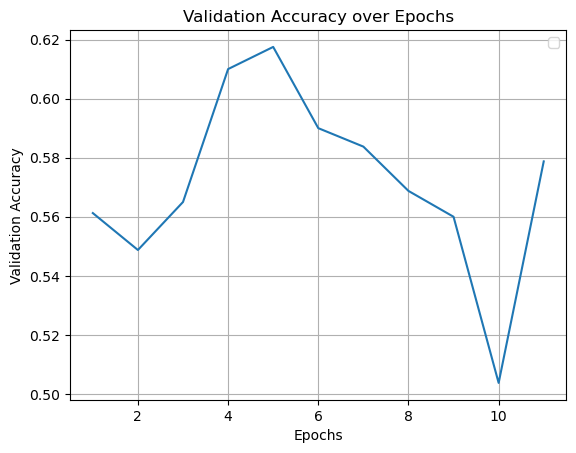

<Figure size 640x480 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt

num_epochs = np.arange(1, len(val_accuracy) + 1)

# Plot the validation accuracy over epochs
plt.plot(num_epochs, val_accuracy)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()
plt.savefig('validation_accuracy_plot.png', dpi=300)

# Let's test the test accuracy our NN

In [31]:
FineTuneModel.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for tdata in test_dataloader:
        tinputs, tlabels = tdata
        ttensor_tuple = ()
        k = 0
        for t in tinputs:
            tpreproc_input = vggish_input.wavfile_to_examples(t, return_tensor = True)
            tpreproc_input = torch.permute(tpreproc_input, (1, 0, 2, 3))
            tpreproc_input = torch.squeeze(tpreproc_input, dim = 0)
            ttensor_tuple += (tpreproc_input,)
            k +=1
    
        tstacked_tensor = torch.stack(ttensor_tuple)
            
        tstacked_tensor, tlabels = tstacked_tensor.to(device), tlabels.to(device)

        # Forward pass
        toutputs = FineTuneModel(tstacked_tensor)

        del tstacked_tensor
        torch.cuda.empty_cache()

        # Calculate the accuracy
        accuracy = calculate_accuracy(toutputs, tlabels)
        correct_predictions += (accuracy * len(tlabels))
        total_predictions += len(tlabels)

# Calculate the overall accuracy
overall_accuracy = correct_predictions / total_predictions
print("Overall accuracy:", overall_accuracy)

Overall accuracy: 0.50625


In [32]:
model_path = 'model_{}_{}'.format(timestamp, epoch_number)
torch.save(FineTuneModel.state_dict(), model_path)

In [37]:
# loading in 5th epoch
best_epoch = FintuneModel()
best_epoch_path = 'model_20230506_101527_4'
best_epoch.load_state_dict(torch.load(best_epoch_path))

best_epoch
best_epoch = best_epoch.to(device) # Move the model to the GPU
best_epoch.eval()

FintuneModel(
  (pretrain): VGGish(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(k

In [38]:
correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for tdata in test_dataloader:
        tinputs, tlabels = tdata
        ttensor_tuple = ()
        k = 0
        for t in tinputs:
            tpreproc_input = vggish_input.wavfile_to_examples(t, return_tensor = True)
            tpreproc_input = torch.permute(tpreproc_input, (1, 0, 2, 3))
            tpreproc_input = torch.squeeze(tpreproc_input, dim = 0)
            ttensor_tuple += (tpreproc_input,)
            k +=1
    
        tstacked_tensor = torch.stack(ttensor_tuple)
            
        tstacked_tensor, tlabels = tstacked_tensor.to(device), tlabels.to(device)

        # Forward pass
        toutputs = best_epoch(tstacked_tensor)

        del tstacked_tensor
        torch.cuda.empty_cache()

        # Calculate the accuracy
        accuracy = calculate_accuracy(toutputs, tlabels)
        correct_predictions += (accuracy * len(tlabels))
        total_predictions += len(tlabels)

# Calculate the overall accuracy
overall_accuracy = correct_predictions / total_predictions
print("Overall accuracy:", overall_accuracy)

Overall accuracy: 0.53375


In [95]:
nn.Softmax()(outputs)

/var/folders/5b/czmgkfjs3m324b4knjhp6r8w0000gn/T/ipykernel_23204/1125075712.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.Softmax()(outputs)


tensor([[0.0317, 0.4522, 0.2882, 0.0197, 0.0787, 0.0365, 0.0483, 0.0448],
        [0.0957, 0.0369, 0.0456, 0.6709, 0.0341, 0.0242, 0.0450, 0.0476],
        [0.1009, 0.1496, 0.2956, 0.0698, 0.1343, 0.0722, 0.0901, 0.0874],
        [0.0512, 0.0155, 0.0280, 0.8217, 0.0152, 0.0126, 0.0261, 0.0298],
        [0.3007, 0.0908, 0.0769, 0.0822, 0.1343, 0.0614, 0.0976, 0.1561],
        [0.0781, 0.0443, 0.0613, 0.6350, 0.0389, 0.0314, 0.0526, 0.0584],
        [0.0880, 0.1424, 0.2745, 0.0716, 0.1076, 0.1101, 0.0922, 0.1136],
        [0.1329, 0.0791, 0.0728, 0.0838, 0.1270, 0.0720, 0.1316, 0.3007]],
       grad_fn=<SoftmaxBackward0>)

# BEFORE THIS IS AS FAR AS WE'VE GOTTEN

In [ ]:
#training on new dataset loop
#initialize variables

epochs = 30
steps = 0
print_every = 100
trainLoss = [] 
testLoss = []

In [8]:
from tqdm import tqdm
import numpy as np

AUDIO_DIR = "../data/fma_small"

for i in tqdm(small.index):
    try:
        embed = model.forward(get_audio_path(AUDIO_DIR, i))
        with open(f'../data/small_embeds/{i}.npy', 'wb') as f:
                np.save(f, embed.detach().numpy())
    except:
        print("error with audio stream, continuing")

 55%|█████▌    | 4425/8000 [4:15:26<1:51:15,  1.87s/it]

error with audio stream, continuing
error with audio stream, continuing
error with audio stream, continuing


 56%|█████▌    | 4471/8000 [4:17:56<2:17:25,  2.34s/it]

error with audio stream, continuing


 61%|██████▏   | 4903/8000 [4:42:17<2:58:23,  3.46s/it]

error with audio stream, continuing


 87%|████████▋ | 6965/8000 [6:35:17<59:08,  3.43s/it]  

error with audio stream, continuing


100%|██████████| 8000/8000 [7:33:28<00:00,  3.40s/it]


In [ ]:
test_embed = model.forward(get_audio_path(AUDIO_DIR, i))


In [326]:
def load_one(idx):
    try:
        embed = np.load(f'../data/small_embeds/{idx}.npy').flatten()
        return embed
    except:
        return np.zeros(31*128)
    
embed_series = pd.Series(small.index).apply(load_one)

In [329]:
embed_series[0].shape

(3968,)

In [10]:
embed_df = pd.DataFrame.from_dict(dict(zip(embed_series.index, embed_series.values))).T
embed_df = embed_df.set_index(small.index)

In [11]:
# filter out tracks that couldn't be read / embedded.

embed_df = embed_df[~(embed_df.sum(axis=1) == 0)]

In [12]:
labels_onehot = LabelBinarizer().fit_transform(small['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=small.index)
labels_onehot.columns = [f'label_{i}' for i in labels_onehot.columns]
labels_onehot

,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7
track_id,,,,,,,,
2,0,0,0,1,0,0,0,0
5,0,0,0,1,0,0,0,0
10,0,0,0,0,0,0,1,0
140,0,0,1,0,0,0,0,0
141,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
154308,0,0,0,1,0,0,0,0
154309,0,0,0,1,0,0,0,0
154413,0,0,0,0,0,0,1,0


In [13]:
labels_onehot = LabelBinarizer().fit_transform(small['track', 'genre_top'])
labels_onehot

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
labels_encoded = LabelEncoder().fit_transform(small['track', 'genre_top'])

In [17]:
small['labels_encoded']

track_id
2         3
5         3
10        6
140       2
141       2
         ..
154308    3
154309    3
154413    6
154414    6
155066    3
Name: labels_encoded, Length: 8000, dtype: int32

In [18]:
data_df = embed_df
data_df['labels_encoded'] = small['labels_encoded']
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3959,3960,3961,3962,3963,3964,3965,3966,3967,labels_encoded
track_id,,,,,,,,,,,,,,,,,,,,,
2,183.0,20.0,128.0,157.0,234.0,103.0,69.0,62.0,133.0,192.0,...,255.0,35.0,177.0,0.0,169.0,0.0,0.0,46.0,255.0,3
5,187.0,11.0,134.0,153.0,210.0,115.0,64.0,56.0,121.0,221.0,...,255.0,179.0,253.0,0.0,255.0,17.0,0.0,215.0,255.0,3
10,189.0,18.0,147.0,126.0,223.0,91.0,111.0,108.0,115.0,185.0,...,71.0,243.0,255.0,62.0,150.0,224.0,0.0,0.0,255.0,6
140,168.0,7.0,168.0,103.0,183.0,88.0,121.0,102.0,142.0,195.0,...,163.0,139.0,174.0,80.0,178.0,160.0,0.0,0.0,255.0,2
141,171.0,9.0,155.0,121.0,177.0,71.0,133.0,105.0,161.0,199.0,...,141.0,142.0,0.0,126.0,91.0,253.0,99.0,64.0,255.0,2


In [11]:
train_df = data_df[data_df.index.isin(train)]
val_df = data_df[data_df.index.isin(val)]
test_df = data_df[data_df.index.isin(test)]

train_df.shape[0], val_df.shape[0], test_df.shape[0]

NameError: name 'data_df' is not defined

In [20]:
DATA_COLS = [col for col in train_df.columns if type(col) == int]
LABEL_COLS = [col for col in train_df.columns if type(col) != int]

In [21]:
X_train = train_df[DATA_COLS].values
y_train = train_df['labels_encoded'].values

In [48]:
y_train

array([3, 3, 6, ..., 6, 6, 3])

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
pca = PCA(n_components=128)
X_pca = pca.fit_transform(X_train_scaled)

In [24]:
clf = RandomForestClassifier()
clf.fit(X_pca, y_train)

RandomForestClassifier()

In [25]:
clf = SVC(C=1, kernel='rbf', gamma='scale')
clf.fit(X_pca, y_train)

SVC(C=1)

In [26]:
X_test = test_df[DATA_COLS].values
y_test = test_df['labels_encoded'].values

In [27]:
X_test_pca = pca.transform(scaler.transform(X_test))

In [28]:
accuracy_score(y_test, clf.predict(X_test_pca))

0.54875

In [29]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
clf.predict(X_test)[0]

7

In [31]:
accuracy_score(y_test, clf.predict(X_test))

0.525

In [33]:
confusion_matrix(y_test, clf.predict(X_test))

array([[76,  8,  1,  3, 10,  1,  1,  0],
       [ 8, 44, 12,  0, 20, 10,  3,  3],
       [ 0, 27, 23,  0,  3, 12, 23, 12],
       [ 9,  4,  0, 78,  1,  4,  3,  1],
       [ 2, 15, 37,  0, 35,  5,  3,  3],
       [ 9,  1, 14,  4,  1, 61,  9,  1],
       [17,  5,  9, 11,  4, 12, 35,  7],
       [ 2, 13,  5,  0,  1,  3,  8, 68]], dtype=int64)

In [34]:
np.load('../data/small_embeds/10.npy').shape

(31, 128)

In [35]:

model.forward(get_audio_path(AUDIO_DIR, train[0]))

tensor([[183.,  20., 128.,  ...,   0., 228., 255.],
        [184.,  14., 135.,  ...,   0., 168., 255.],
        [185.,  16., 131.,  ...,   0., 205., 255.],
        ...,
        [186.,  19., 139.,  ...,   0., 243., 255.],
        [183.,  19., 123.,  ...,  95., 143., 255.],
        [182.,  21., 136.,  ...,   0.,  46., 255.]],
       grad_fn=<SqueezeBackward0>)

In [36]:
i

155066